In [49]:
# set to false if working on local machine
onColab = True

def preprocess_input(x):
  return tensorflow.keras.applications.inception_v3.preprocess_input(x)

model = tfk.applications.VGG16(
      include_top=False, # we remove the classifier
      weights="imagenet",
      input_shape=(img_h * 2, img_w * 2, 3)
  )

58900480/58889256 [==============================] - 2s 0us/step


In [50]:
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE1/
  !ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/ANN/CHALLENGE1
01-Challenge.ipynb  checkpoints        model.png	    test
baseline_best	    dataset.zip        plotting.ipynb	    training
carpa.ipynb	    inceptionv_3_best  resnet50_best_false  trySubmission.ipynb


In [51]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [52]:
dataset_path = './training'
test_path = './test'
isTest = True
epochs = 200
batch_size = 8
validation_split = 0.2
img_h, img_w = (256, 256)
seed = 20

def load_data(dontUseFun=True, fun=None):
  image_generator = ImageDataGenerator(preprocessing_function = fun, validation_split=validation_split)  
  if dontUseFun:
    image_generator = ImageDataGenerator(rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect',
                                          rescale=1./255, 
                                          validation_split=0.2)  


  # Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
  train_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='training',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)

  valid_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='validation',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)
  test_gen = None
  if isTest:
    test_image_gen = ImageDataGenerator(preprocessing_function = fun)
    if dontUseFun:
      test_image_gen = ImageDataGenerator(rescale=1./255)
    test_gen = test_image_gen.flow_from_directory(directory=test_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)
  return train_gen, valid_gen, test_gen


train_gen, valid_gen, test_gen = load_data(True, preprocess_input)

Found 12395 images belonging to 14 classes.
Found 3089 images belonging to 14 classes.
Found 2075 images belonging to 11 classes.


In [53]:
# model = tfk.models.load_model("./" + model_dir)

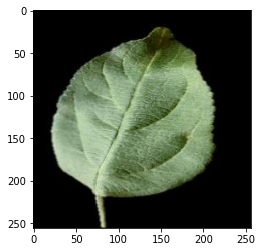

In [54]:
# Get sample batch
batch = next(test_gen)[0]

# Get first image
image = batch[3] # batch size = 8

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image*255))

# Get the activations (the output of each ReLU layer)
# We can do it by creating a new Model (activation_model) with the same input as 
# the original model and all the ReLU activations as output
layers = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=model.input, outputs=layers)
# Finally we get the output feature maps (for each layer) given the imput test image
fmaps = activation_model.predict(tf.expand_dims(tfkl.Resizing(img_h * 2, img_w * 2, interpolation="bicubic")(image)
, 0))

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth=0, first_n=-1): 
  # fmaps: list of all the feature maps for each layer
  # depth: the layer we want to visualize (an int in [0, network depth))
  # first_n: default '-1' means 'all activations'. Number of activations to be visualized. Note that for deep layers it could be a large number.

  fmaps = fmaps[depth] # get feature maps at the desired depth
  if first_n > 0:
    fmaps = fmaps[0, :, :, :first_n] 

  fmaps = tf.image.resize(fmaps, size=[128, 128]) # resize for visualization

  # Distribute on a grid for plotting
  col_size = 8
  row_size = fmaps.shape[-1] // 8
  fmap_channel=0
  fig = plt.figure(figsize=(30, 30))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(row_size, col_size),  
                  axes_pad=0.1,  # pad between axes in inch.
                  )
  for row in range(0,row_size):
      for col in range(0,col_size):
          grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
          fmap_channel += 1
  plt.show()

In [ ]:
display_activation(fmaps=fmaps, depth=2, first_n=-1)